## NN approach

Goals: use hyperband within keras tuner library to find the best hyperparameters while trying to reach the highest performance (roc_auc, accuracy, precision/recall tradeoff)

Data to try out:
- scaled modified data X
- scaled data with 1h encoding 
- imbalanced data possibly with class weights X
- balanced data X

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [2]:
raw_data = pd.read_csv('BankChurners.csv', index_col = 0)
mod_data = pd.read_csv('bc_re.csv', index_col = 0)

In [3]:
mod_data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Avg_Utilization_Ratio
CLIENTNUM,,,,,,,,,,,,,,,,,,
768805383,0,45,0,3,0,1,2.0,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,0.061
818770008,0,49,1,5,0,0,1.0,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,0.105
713982108,0,51,0,3,0,1,3.0,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,0.000
769911858,0,40,1,4,0,0,1.0,0,34,3,4,1,3313.0,2517,796.0,1.405,1171,0.760
709106358,0,40,0,3,0,1,2.0,0,21,5,1,0,4716.0,0,4716.0,2.175,816,0.000


In [4]:
X = mod_data.copy()
y = X.pop('Attrition_Flag')

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1000)

#I'll need the validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 1000)

In [6]:
from sklearn.preprocessing import RobustScaler

x_sclr = RobustScaler()

X_train = x_sclr.fit_transform(X_train) #this is now ndarray, don't need pd df anyway
X_test = x_sclr.transform(X_test)
X_valid = x_sclr.transform(X_valid)

In [7]:
type(X_train)

numpy.ndarray

### KerasTuner

taken from tf documentation

In [8]:
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

In [9]:
def model_builder(hp):
    model = keras.Sequential()
    
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
    
    hp_units1 = hp.Int('units1', min_value = 32, max_value = 512, step = 32)
    model.add(keras.layers.Dense(units = hp_units1, activation = 'relu'))
    
    model.add(keras.layers.Dense(1, activation = 'sigmoid')) #logit
    
    hp_lr = hp.Choice('learning_rate', values = [1e-2, 3e-3, 1e-3, 5e-4, 1e-4])
    
    adam = keras.optimizers.Adam(learning_rate = hp_lr)
    
    recall = keras.metrics.Recall()
    auc = keras.metrics.AUC()
    
    model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = [recall, auc])
    
    return model

In [10]:
#let's max recall
tuner = kt.Hyperband(model_builder, objective = kt.Objective("val_recall", direction="max"),
                     max_epochs = 50, factor = 3, directory = 'kt', project_name = 'kt_1')

In [11]:
import IPython

In [12]:
class ClearTrainingOutput(keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)

In [13]:
tuner.search(X_train, y_train, epochs = 100, validation_data = (X_valid, y_valid), callbacks = [ClearTrainingOutput()])

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, the optimal number of units in the second densely-connected layer
is {best_hps.get('units1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 90 Complete [00h 00m 19s]
val_recall: 0.8373494148254395

Best val_recall So Far: 0.849397599697113
Total elapsed time: 00h 06m 47s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 320, the optimal number of units in the second densely-connected layer
is 256 and the optimal learning rate for the optimizer
is 0.003.



Oracle triggered exit = the models within the search have collided

Let's see.

In [19]:
def train_model(lr, units, units1, epochs, X = X_train, y = y_train, Xv = X_valid, yv = y_valid):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = units, activation = 'relu'))
    model.add(keras.layers.Dense(units = units1, activation = 'relu'))
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))
    adam = keras.optimizers.Adam(learning_rate = lr)
    recall = keras.metrics.Recall()
    auc = keras.metrics.AUC()
    model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = [recall, auc])
    ES = keras.callbacks.EarlyStopping(monitor = 'val_recall_3', restore_best_weights = True, patience = 3, mode = 'max')
    history = model.fit(X, y, epochs = epochs, validation_data = (Xv, yv), callbacks = [ES])
    
    plt.plot(history.history['val_recall_3'], 'r', label = 'val_recall')
    plt.legend()
    plt.title('Training loss and recall')
    plt.show()
    
    return model

Epoch 1/50
254/254 [==============================] - 1s 2ms/step - loss: 0.3136 - recall_3: 0.4035 - auc_3: 0.8438 - val_loss: 0.3183 - val_recall_3: 0.3916 - val_auc_3: 0.8696
Epoch 2/50
254/254 [==============================] - 0s 1ms/step - loss: 0.2377 - recall_3: 0.5810 - auc_3: 0.9210 - val_loss: 0.2455 - val_recall_3: 0.4819 - val_auc_3: 0.9285
Epoch 3/50
254/254 [==============================] - 0s 1ms/step - loss: 0.1983 - recall_3: 0.6590 - auc_3: 0.9486 - val_loss: 0.1959 - val_recall_3: 0.6988 - val_auc_3: 0.9552
Epoch 4/50
254/254 [==============================] - 0s 1ms/step - loss: 0.1662 - recall_3: 0.7323 - auc_3: 0.9646 - val_loss: 0.1877 - val_recall_3: 0.7048 - val_auc_3: 0.9563
Epoch 5/50
254/254 [==============================] - 0s 1ms/step - loss: 0.1561 - recall_3: 0.7539 - auc_3: 0.9691 - val_loss: 0.1794 - val_recall_3: 0.7590 - val_auc_3: 0.9617
Epoch 6/50
254/254 [==============================] - 0s 1ms/step - loss: 0.1372 - recall_3: 0.7840 - auc_3: 0

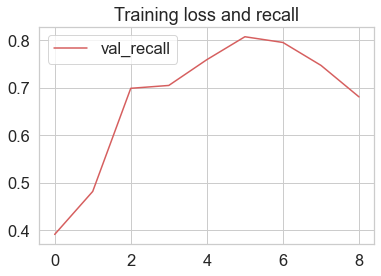

In [20]:
model_1 = train_model(lr = 0.003, units = 320, units1 = 256, epochs = 50)

In [21]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap = 'Greens')
    plt.title('Confusion matrix at probability: {:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    print('No churn detected (True Negatives): ', cm[0][0])
    print('Churn Incorrectly Detected (False Positives): ', cm[0][1])
    print('Churn Missed (False Negatives): ', cm[1][0])
    print('Churn Detected (True Positives): ', cm[1][1])
    print('Total Churns: ', np.sum(cm[1]))
    
    print('Model precision: ', cm[1][1]/(cm[1][1]+cm[0][1]))
    print('Model recall: ', cm[1][1]/(cm[1][1]+cm[1][0]))
    print('Model accuracy: ', (cm[1][1]+cm[0][0])/len(labels))

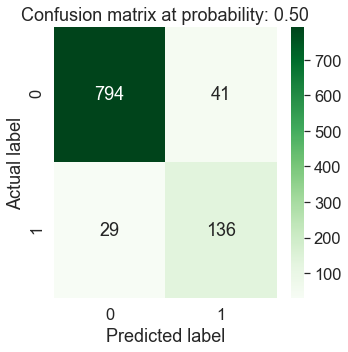

No churn detected (True Negatives):  794
Churn Incorrectly Detected (False Positives):  41
Churn Missed (False Negatives):  29
Churn Detected (True Positives):  136
Total Churns:  165
Model precision:  0.768361581920904
Model recall:  0.8242424242424242
Model accuracy:  0.93


In [22]:
y_pred_1 = model_1.predict(X_test)
plot_cm(y_test, y_pred_1)

### Brief commentary on this part

So as I suspected the NN does not have enough data to push the threshold on this task a little further. However, the hyperband algorithm works quite well, the only thing to take care of is the plethora of callbacks and the right objective of them (if I feed EarlyStopping a val_recall as a monitored metric, I should make sure the callback tries to max it, not minimize it)

For the next step I will try to bring in the synthesized data using SMOTE. Let's see about its performance.

In [23]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [24]:
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
under = RandomUnderSampler(sampling_strategy = 1, random_state = 42)
seq = [('over',over),('under',under)]
pipeline = Pipeline(steps=seq)

X_train_bal, y_train_bal = pipeline.fit_resample(X_train, y_train)
X_valid_bal, y_valid_bal = pipeline.fit_resample(X_valid, y_valid)

print('Training size:',len(X_train_bal))
print('Train positives', Counter(y_train_bal)[1])
print('Valid size:', len(X_valid_bal))
print('Valid positives', Counter(y_valid_bal)[1])

Training size: 6830
Train positives 3415
Valid size: 834
Valid positives 417


In [25]:
tuner = kt.Hyperband(model_builder, objective = kt.Objective("val_recall", direction="max"),
                     max_epochs = 50, factor = 3, directory = 'kt', project_name = 'kt_bal_1')

In [26]:
tuner.search(X_train_bal, y_train_bal, epochs = 100, validation_data = (X_valid_bal, y_valid_bal), callbacks = [ClearTrainingOutput()])

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, the optimal number of units in the second densely-connected layer
is {best_hps.get('units1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 90 Complete [00h 00m 12s]
val_recall: 0.8992805480957031

Best val_recall So Far: 0.9520383477210999
Total elapsed time: 00h 06m 18s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 416, the optimal number of units in the second densely-connected layer
is 448 and the optimal learning rate for the optimizer
is 0.003.



In [30]:
def train_model_bal(lr, units, units1, epochs, X = X_train_bal, y = y_train_bal, Xv = X_valid_bal, yv = y_valid_bal):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = units, activation = 'relu'))
    model.add(keras.layers.Dense(units = units1, activation = 'relu'))
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))
    adam = keras.optimizers.Adam(learning_rate = lr)
    recall = keras.metrics.Recall()
    auc = keras.metrics.AUC()
    model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = [recall, auc])
    ES = keras.callbacks.EarlyStopping(monitor = 'val_recall_2', restore_best_weights = True, patience = 3, mode = 'max')
    history = model.fit(X, y, epochs = epochs, validation_data = (Xv, yv), callbacks = [ES])
    
    plt.plot(history.history['val_recall_2'], 'r', label = 'val_recall')
    plt.legend()
    plt.title('Training loss and recall')
    plt.show()
    
    return model

Epoch 1/50
214/214 [==============================] - 1s 3ms/step - loss: 0.4030 - recall_2: 0.8152 - auc_2: 0.8975 - val_loss: 0.3879 - val_recall_2: 0.8633 - val_auc_2: 0.9095
Epoch 2/50
214/214 [==============================] - 0s 2ms/step - loss: 0.2984 - recall_2: 0.8878 - auc_2: 0.9458 - val_loss: 0.3780 - val_recall_2: 0.8969 - val_auc_2: 0.9254
Epoch 3/50
214/214 [==============================] - 0s 2ms/step - loss: 0.2355 - recall_2: 0.9089 - auc_2: 0.9658 - val_loss: 0.3009 - val_recall_2: 0.8729 - val_auc_2: 0.9473
Epoch 4/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1970 - recall_2: 0.9288 - auc_2: 0.9758 - val_loss: 0.2450 - val_recall_2: 0.9209 - val_auc_2: 0.9627
Epoch 5/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1743 - recall_2: 0.9406 - auc_2: 0.9805 - val_loss: 0.3040 - val_recall_2: 0.8705 - val_auc_2: 0.9502
Epoch 6/50
214/214 [==============================] - 0s 2ms/step - loss: 0.1460 - recall_2: 0.9488 - auc_2: 0

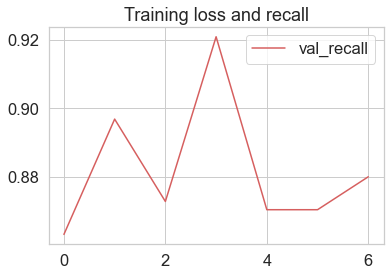

In [31]:
model_bal_1 = train_model_bal(lr = 0.003, units = 416, units1 = 448, epochs = 50)

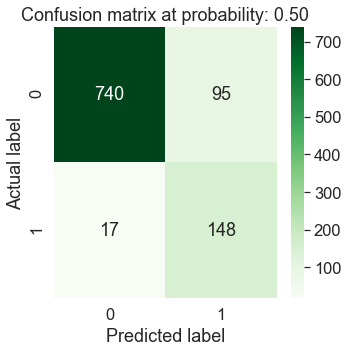

No churn detected (True Negatives):  740
Churn Incorrectly Detected (False Positives):  95
Churn Missed (False Negatives):  17
Churn Detected (True Positives):  148
Total Churns:  165
Model precision:  0.6090534979423868
Model recall:  0.896969696969697
Model accuracy:  0.888


In [33]:
y_pred_bal_1 = model_bal_1.predict(X_test)
plot_cm(y_test, y_pred_bal_1)

### Brief commentary on this part

Balancing apparently helps but focusing on recall only has taken its tax - the overall performance is very much FN-oriented and does not generalize very well, the precision rate has dropped, which was expected, the recall is close to 0.9, which is not bad.

I have found that balancing in this case helps, so the next step will be re-reformatting the data using one-hot encoding on all categorical features. Let's see whether that pushes the general performance any further or not. After that I'll try to extract the feature importances using SHAP module.